In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

ModuleNotFoundError: No module named 'torch'

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=256):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        return x.flatten(2).transpose(1, 2)

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = 1.0 / sqrt(self.head_dim)

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.out_proj(x)

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(self.act(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, int(embed_dim * mlp_ratio), embed_dim, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, n_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, n_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        return self.head(x[:, 0])

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 28.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            total += y.size(0)
            correct += (preds == y).sum().item()
    return 100. * correct / total

def train(model, train_loader, test_loader, criterion, optimizer, scheduler, max_epochs=100, target_acc=95.0):
    for epoch in range(1, max_epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        scheduler.step()
        train_acc = 100. * correct / total
        test_acc = evaluate(model, test_loader)

        print(f"Epoch {epoch}/{max_epochs} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

        if test_acc >= target_acc:
            print(f"\n🎯 Target accuracy {target_acc}% reached. Stopping early at epoch {epoch}!")
            break

In [ ]:
model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

train(model, train_loader, test_loader, criterion, optimizer, scheduler)

Epoch 1/100 | Loss: 1.7521 | Train Acc: 34.19% | Test Acc: 46.30%
Epoch 2/100 | Loss: 1.4414 | Train Acc: 47.37% | Test Acc: 50.66%
Epoch 3/100 | Loss: 1.3263 | Train Acc: 51.59% | Test Acc: 54.62%
Epoch 4/100 | Loss: 1.2558 | Train Acc: 54.45% | Test Acc: 56.58%
Epoch 5/100 | Loss: 1.2120 | Train Acc: 56.31% | Test Acc: 59.22%
Epoch 6/100 | Loss: 1.1743 | Train Acc: 57.61% | Test Acc: 59.26%
Epoch 7/100 | Loss: 1.1425 | Train Acc: 58.74% | Test Acc: 60.48%
Epoch 8/100 | Loss: 1.1163 | Train Acc: 59.64% | Test Acc: 62.04%
Epoch 9/100 | Loss: 1.0891 | Train Acc: 60.86% | Test Acc: 60.91%
Epoch 10/100 | Loss: 1.0623 | Train Acc: 61.72% | Test Acc: 63.56%
Epoch 11/100 | Loss: 1.0101 | Train Acc: 63.70% | Test Acc: 65.65%
Epoch 12/100 | Loss: 0.9874 | Train Acc: 64.43% | Test Acc: 66.14%
Epoch 13/100 | Loss: 0.9623 | Train Acc: 65.51% | Test Acc: 67.31%
Epoch 14/100 | Loss: 0.9488 | Train Acc: 65.79% | Test Acc: 66.37%
Epoch 15/100 | Loss: 0.9262 | Train Acc: 66.52% | Test Acc: 68.74%
Epoc

In [ ]:
torch.save(model.state_dict(), "model.h5")

FileUpload(value={}, accept='image/*', description='Upload')

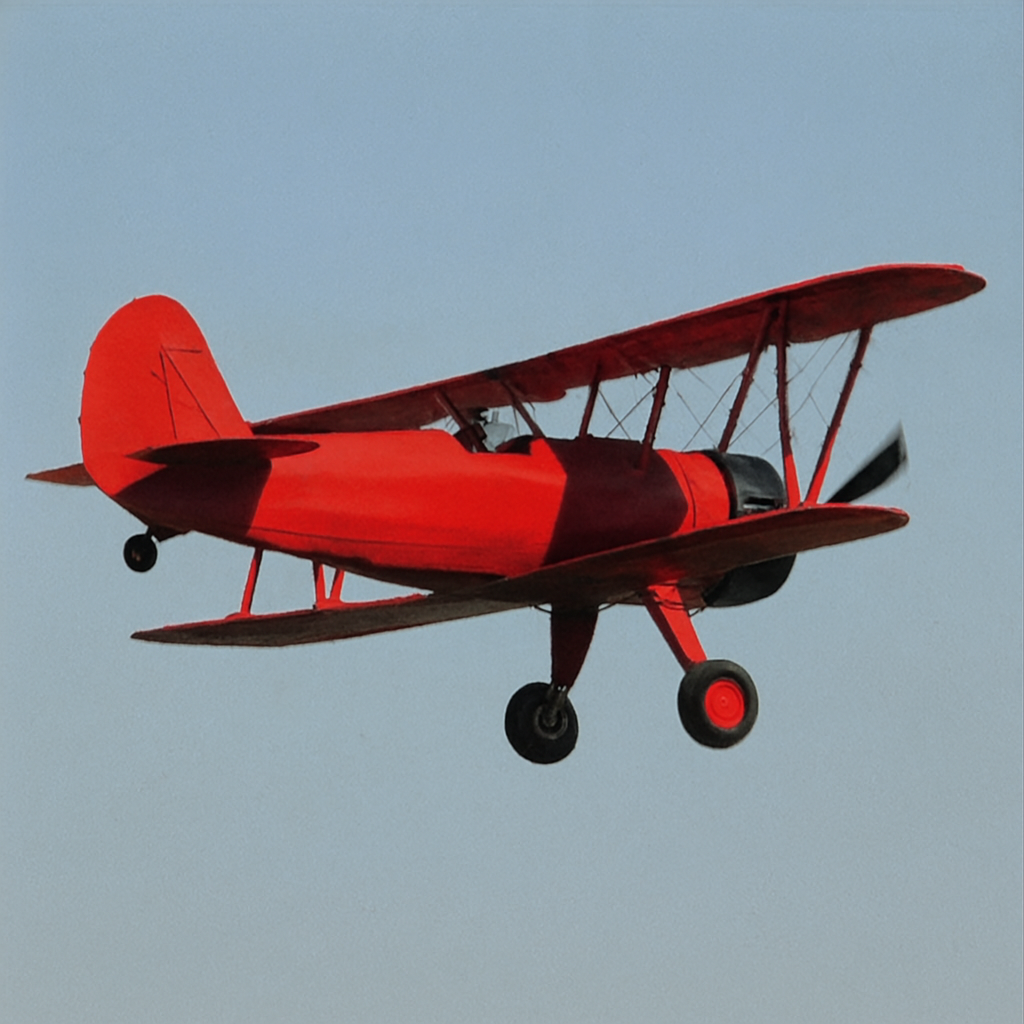

Predicted Class: airplane


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import ipywidgets as widgets
from IPython.display import display
import io

# Set model to eval mode
model.eval()

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Transform (same as during training)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Upload widget
upload = widgets.FileUpload(accept='image/*', multiple=False)
display(upload)

# Function to handle the uploaded image
def on_upload_change(change):
    for name, file_info in upload.value.items():
        img_data = file_info['content']
        img = Image.open(io.BytesIO(img_data)).convert('RGB')
        display(img)  # Show the image

        # Transform image and predict
        input_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            class_index = predicted.item()

        print(f"Predicted Class: {classes[class_index]}")

upload.observe(on_upload_change, names='value')

In [ ]:
torch.save(model.state_dict(), "model.h5")